Import necessary libraries

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer
from prettytable import PrettyTable
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

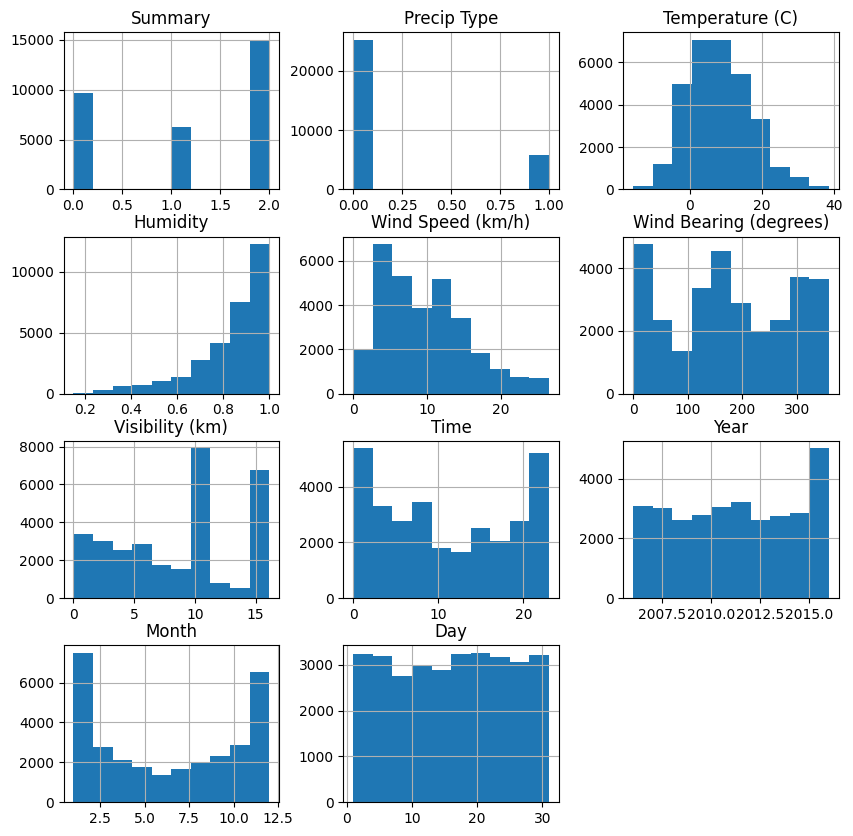

In [2]:
data = pd.read_csv('last_data.csv')
data = data.drop('Unnamed: 0', axis=1)
data.hist(figsize=(10,10))
X = data.drop('Summary', axis=1)
y = data['Summary']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                   random_state=42,  
                                   test_size=0.3)

In [3]:
def checking_overfitting_undefitting(y_train, y_train_pred, y_test, y_test_pred):
    """
    Print whether the model is underfit, overfit or good fit.
    
    y_train = training data
    y_train_pred = predictions on training data
    y_test = testing data
    y_test_pred = predictions on testing data
    """
    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    if training_accuracy<=0.65:
        print("Model is underfitting.") 
    elif training_accuracy>0.65 and abs(training_accuracy-testing_accuracy)>0.15:
        print("Model is overfitting.")
    else:
        print("Model is not underfitting/overfitting.")

Create class to find Classification metrics and draw confusion matrix

In [61]:
class class_metrics_formula:
    def __init__(self, model_name, y_test, y_pred, y_prob=None):
        self.model_name = model_name
        self.y_test = y_test
        self.y_pred = y_pred
        self.y_prob = y_prob
        # self.metrics_table = None
        self.confusion_mat = None
        self.TP = None
        self.FP = None
        self.FN = None
        self.TN = None
        
        
        
    def calculate_confusion_matrix(self):
        self.confusion_mat = confusion_matrix(self.y_test, self.y_pred)
        self.TP = self.confusion_mat.diagonal()
        self.FP = self.confusion_mat.sum(axis=0) - self.TP
        self.FN = self.confusion_mat.sum(axis=1) - self.TP
        self.TN = self.confusion_mat.sum() - (self.TP + self.FP + self.FN)
        return self.confusion_mat
        
        
    def accuracy(self):
        if len(self.y_test) != len(self.y_pred):
            raise ValueError("Input arrays must have the same length.")

        # Count the number of correct predictions
        correct_predictions = sum(1 for true, pred in zip(self.y_test, self.y_pred) if true == pred)

        # Calculate accuracy
        accuracy = correct_predictions / len(self.y_test)

        return accuracy
    
    def calculate_auc_multiclass(self):
        lb = LabelBinarizer()
        self.y_test_bin = lb.fit_transform(y_test)
        auc_scores = []
        unique_classes = np.unique(self.y_test)

        # Number of unique classes
        num_classes = len(unique_classes)
        for class_label in range(num_classes):
            # Binarize the true labels for the current class
            y_true_bin = [1 if label == class_label else 0 for label in self.y_test]

            # Combine true labels and predicted probabilities
            data = list(zip(y_true_bin, self.y_prob[:, class_label]))

            # Sort the data by predicted probabilities in descending order
            sorted_data = sorted(data, key=lambda x: x[1], reverse=True)

            # Initialize variables for true positive and false positive counts
            tp_count = 0
            fp_count = 0

            # Initialize variables for previous true positive and false positive rates
            prev_tpr = 0
            prev_fpr = 0

            # Initialize AUC for the current class
            auc_class = 0.0

            # Iterate through the sorted data
            for true_label, prob in sorted_data:
                # Update true positive or false positive count based on the true label
                if true_label == 1:
                    tp_count += 1
                else:
                    fp_count += 1

                # Calculate true positive rate (sensitivity) and false positive rate
                tpr = tp_count / sum(y_true_bin)
                fpr = fp_count / (len(y_true_bin) - sum(y_true_bin))

                # Update AUC using the trapezoidal rule
                auc_class += ((fpr - prev_fpr) * (prev_tpr + tpr)) / 2

                # Update previous true positive and false positive rates
                prev_tpr = tpr
                prev_fpr = fpr

            auc_scores.append(auc_class)
        

        # Calculate macro-average AUC
        macro_average_auc = sum(auc_scores) / num_classes

        return macro_average_auc
    
    def precision(self):
        self.prec_score = self.TP/(self.TP+self.FP)
        return self.prec_score.mean()


    def recall(self):
        self.rec_score = self.TP/(self.TP+self.FN)
        return self.rec_score.mean()


    def f_one_score(self):
        f_1_score = (2 * self.prec_score * self.rec_score) / (self.prec_score + self.rec_score)
        return f_1_score.mean()
    
    def draw_confusion_matrix(self):
    
        self.confusion_mat = confusion_matrix(self.y_test, self.y_pred)

        # Plot the confusion matrix as a heatmap
        plt.figure(figsize=(8,6))
        sns.heatmap(self.confusion_mat, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        return plt.show()
    def get_metrics(self):
        return {
            "Model": self.model_name,
            'Confusion matrix': self.calculate_confusion_matrix(),
            "Accuracy": self.accuracy(),
            "AUC": self.calculate_auc_multiclass(),
            "Precision": self.precision(),
            "Recall": self.recall(),
            "F1 Score": self.f_one_score()
        }
    

In [38]:
class ClassificationMetrics:
    def __init__(self, model_name, y_true, y_pred, y_prob):
        self.model_name = model_name
        self.y_true = y_true
        self.y_pred = y_pred
        self.y_prob = y_prob
        self.y_test_bin = None

    def calculate_accuracy(self):
        return accuracy_score(self.y_true, self.y_pred)

    def calculate_precision(self):
        return precision_score(self.y_true, self.y_pred, average='weighted')

    def calculate_recall(self):
        return recall_score(self.y_true, self.y_pred, average='weighted')

    def calculate_f1_score(self):
        return f1_score(self.y_true, self.y_pred, average='weighted')

    def calculate_auc(self):
        lb=LabelBinarizer()
        self.y_test_bin = lb.fit_transform(self.y_true)
        all_fpr = []
        all_tpr = []
        all_auc = []
        unique_classes = np.unique(self.y_true)   # Number of unique classes
        num_classes = len(unique_classes)
        # Calculate ROC curve and AUC for each class
        for i in range(num_classes):
            fpr, tpr, thresholds = roc_curve(self.y_test_bin[:, i], self.y_prob[:, i])
            roc_auc = auc(fpr, tpr)
            
            all_fpr.append(fpr)
            all_tpr.append(tpr)
            all_auc.append(roc_auc)

        # Calculate macro-average ROC AUC
        macro_average_auc = sum(all_auc) / num_classes
        return macro_average_auc
    
    def get_metrics(self):
        return {
            "Model": self.model_name,
            "Accuracy": self.calculate_accuracy(),
            "AUC": self.calculate_auc(),
            "Precision": self.calculate_precision(),
            "Recall": self.calculate_recall(),
            "F1 Score": self.calculate_f1_score()
        }

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# joblib.dump(scaler, "scaler.pkl")

Models
SVM     
KNN
Random Forest
Gradient Booster Classifier
Extra Tree Classifier


Metrics
Accuracy    AUC     Precision   Recall  F1      Confusion mettrix

In [6]:
#Create dict with hyperparameters
param_grid_svc = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': [0.001, 0.01, 0.1]}
# Create an SVM classifier
svm = SVC()
# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(svm, param_grid_svc)
grid_search.fit(X_train, y_train)
# The best hyperparameters are in grid_search.best_params_
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


Train our data with best hyperparametres and find proba for auc score

In [7]:
my_svc = SVC(C=10, gamma=0.1, kernel='rbf', probability=True)
my_svc.fit(X_train, y_train)
y_pred_svm = my_svc.predict(X_test)
y_train_svm = my_svc.predict(X_train)
checking_overfitting_undefitting(y_train, y_train_svm, y_test, y_pred_svm)

y_prob_svc = my_svc.predict_proba(X_test)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results = cross_val_score(my_svc, X, y, cv=kfold)
results.mean()

Model is not underfitting/overfitting.


0.628408337612136


KNN

In [8]:
#find hyperparameters for KNN Classifier
param_grid_knn = {'n_neighbors': np.arange(1, 11),
                  'weights': ['uniform', 'distance'],
                  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                  'p': [1, 2]}
knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)
print("Best Hyperparameters:", grid.best_params_)
print("Best Accuracy:", grid.best_score_)

Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best Accuracy: 0.8839355645297765


In [9]:
best_knn = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'],
                                 weights=grid.best_params_['weights'],
                                 algorithm=grid.best_params_['algorithm'],
                                 p=grid.best_params_['p'])
best_knn.fit(X_train, y_train)
y_pred_knn = best_knn.predict(X_test)
y_prob_knn = best_knn.predict_proba(X_test)
y_train_knn = best_knn.predict(X_train)
checking_overfitting_undefitting(y_train, y_train_knn, y_test, y_pred_knn)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results_knn = cross_val_score(best_knn, X, y, cv=kfold)
results_knn.mean()

Model is not underfitting/overfitting.


0.8193243457606458

Random forest Classifier

In [10]:

param_grid_rf = {'n_estimators': [25, 50, 10, 125, 150],
                 'max_features': ['sqrt', 'log2', None],
                 'max_depth': [3, 6, 9],
                 'max_leaf_nodes': [3, 6, 9]}
rf = RandomForestClassifier()
grid_search_rf = GridSearchCV(rf, param_grid=param_grid_rf)
grid_search_rf.fit(X_train, y_train)
print(grid_search_rf.best_params_)


{'max_depth': 6, 'max_features': None, 'max_leaf_nodes': 9, 'n_estimators': 10}


In [11]:
grid_rf = RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9, n_estimators=10)
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.predict(X_test)
y_train_rf = grid_rf.predict(X_train)
checking_overfitting_undefitting(y_train, y_train_rf, y_test, y_pred_rf)
y_prob_rf = grid_rf.predict_proba(X_test)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results_rf = cross_val_score(grid_rf, X, y, cv=kfold)
results_rf.mean()

Model is not underfitting/overfitting.


0.8086639177968967

GradientBoostingClassifier

In [12]:

param_grid_gbc = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7]
}

gbc = GradientBoostingClassifier()
grid_gbc = GridSearchCV(gbc, param_grid=param_grid_gbc)
grid_gbc.fit(X_train, y_train)
print(grid_gbc.best_params_)



{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}


In [14]:
grid_gbc_best = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=7)
grid_gbc_best.fit(X_train, y_train)
y_pred_gbc = grid_gbc_best.predict(X_test)
y_train_gbc = grid_gbc_best.predict(X_train)
checking_overfitting_undefitting(y_train, y_train_gbc, y_test, y_pred_gbc)

y_prob_gbc = grid_gbc_best.predict_proba(X_test)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results_gbc = cross_val_score(grid_gbc_best, X, y, cv=kfold)
results_gbc.mean()

Model is not underfitting/overfitting.


0.9322913509745234

In [15]:
#Extra TRee Classifier
grid_params_etc = {'max_depth': [None, 5],
                   'class_weight': [None, 'balanced'],
                   'min_samples_split': [None, 2, 5],
                   'criterion':['gini','log_loss','entropy']
                   }
etc = ExtraTreesClassifier()
grid_etc = GridSearchCV(etc, param_grid=grid_params_etc)
grid_etc.fit(X_train, y_train)
print(grid_etc.best_params_)


/Users/iroda-macbook/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/iroda-macbook/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/iroda-macbook/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/Users/iroda-macbook/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py", line 600, 

{'class_weight': None, 'criterion': 'log_loss', 'max_depth': None, 'min_samples_split': 2}


In [16]:
etc_best = ExtraTreesClassifier(class_weight=None, criterion='log_loss', max_depth=None, min_samples_split=2)
etc_best.fit(X_train, y_train)
y_pred_etc = etc_best.predict(X_test)
y_train_etc = etc_best.predict(X_train)
checking_overfitting_undefitting(y_train, y_train_etc, y_test, y_pred_etc)
y_prob_etc = etc_best.predict_proba(X_test)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
results_etc = cross_val_score(etc_best, X, y, cv=kfold)
results_etc.mean()

Model is not underfitting/overfitting.


0.9334864309776961

In [36]:
y_probs = np.array([y_pred_svm, y_pred_knn, y_pred_rf, y_pred_gbc, y_pred_etc])
y_probs

array([[1, 1, 2, ..., 2, 2, 2],
       [1, 1, 2, ..., 2, 2, 1],
       [1, 1, 2, ..., 2, 0, 2],
       [1, 1, 2, ..., 2, 2, 2],
       [1, 1, 2, ..., 2, 2, 2]])

In [39]:
models = ["SVM Classifier", "KNN", "Random Forest", "Gradient Boost", "Extra Tree Classifier"]
all_metrics = []
y_probs = np.array([y_prob_svc, y_prob_knn, y_prob_rf, y_prob_gbc, y_prob_etc])
y_preds = np.array([y_pred_svm, y_pred_knn, y_pred_rf, y_pred_gbc, y_pred_etc])

#for SVM Classifier
for model, y_prob, y_pred in zip(models, y_probs, y_preds):
    metrics = ClassificationMetrics(model, y_test, y_pred, y_prob)
    all_metrics.append(metrics.get_metrics())

# Create a PrettyTable for the final table
table = PrettyTable()
table.field_names = ["Model", "Accuracy", "AUC", "Precision", "Recall", "F1 Score"]

# Add rows to the table
for metrics in all_metrics:
    table.add_row([metrics["Model"], metrics["Accuracy"], metrics["AUC"], metrics["Precision"], metrics["Recall"], metrics["F1 Score"]])

# Print the final table
print(table)

+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|         Model         |      Accuracy      |        AUC         |     Precision      |       Recall       |      F1 Score      |
+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     SVM Classifier    | 0.8760633143103262 | 0.9646649510457755 | 0.8750126878080591 | 0.8760633143103262 | 0.875156182836102  |
|          KNN          | 0.894260794659201  | 0.967623767098142  | 0.8943273293995365 | 0.894260794659201  | 0.8942361800895275 |
|     Random Forest     | 0.8054269408851082 | 0.9174209530039589 | 0.8054777458023261 | 0.8054269408851082 | 0.7981483795441057 |
|     Gradient Boost    | 0.9247334984386777 | 0.9843829128160531 | 0.924524980577963  | 0.9247334984386777 | 0.9245689889939814 |
| Extra Tree Classifier | 0.9216108538817702 | 0.9838468565217876 | 0.9212279118226

In [62]:
models = ["SVM Classifier", "KNN", "Random Forest", "Gradient Boost", "Extra Tree Classifier"]
all_metrics = []
y_probs = np.array([y_prob_svc, y_prob_knn, y_prob_rf, y_prob_gbc, y_prob_etc])
y_preds = np.array([y_pred_svm, y_pred_knn, y_pred_rf, y_pred_gbc, y_pred_etc])

#for SVM Classifier
for model, y_prob, y_pred in zip(models, y_probs, y_preds):
    metrics = class_metrics_formula(model, y_test, y_pred, y_prob)
    all_metrics.append(metrics.get_metrics())

# Create a PrettyTable for the final table
table = PrettyTable()
table.field_names = ["Model",'Confusion matrix', "Accuracy", "AUC", "Precision", "Recall", "F1 Score"]

# Add rows to the table
for metrics in all_metrics:
    table.add_row([metrics["Model"], metrics["Confusion matrix"], metrics["Accuracy"], metrics["AUC"], metrics["Precision"], metrics["Recall"], metrics["F1 Score"]])

# Print the final table
print('Metrics by formula')
print(table)

Metrics by formula
+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|         Model         |  Confusion matrix  |      Accuracy      |        AUC         |     Precision      |       Recall       |      F1 Score      |
+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     SVM Classifier    | [[2292   23  617]  | 0.8760633143103262 | 0.9646649510457834 | 0.8883377378307943 | 0.8872419831038393 | 0.8874095197261721 |
|                       |  [   4 1858   15]  |                    |                    |                    |                    |                    |
|                       |  [ 455   37 3986]] |                    |                    |                    |                    |                    |
|          KNN          | [[2582   50  300]  | 0.894260794659201  | 0

In [69]:
print("Cross Validation for Classification")
print("SVM Classifier: ", results, '\n', "Average", results.mean())
print()
print("KNN Classifier: ", results_knn, '\n', "Average", results_knn.mean())
print()
print("Random Forest Classifier: ", results_rf,'\n', "Average", results_rf.mean())
print()
print("Gradient Boosts Classifier: ", results_gbc,'\n', "Average", results_gbc.mean())
print()
print("Extra Trees Classifier: ", results_etc,'\n', "Average", results_etc.mean())

Cross Validation for Classification
SVM Classifier:  [0.63598191 0.61111111 0.62887597 0.63049096 0.62370801 0.63178295
 0.62358643 0.62746365 0.63489499 0.6361874 ] 
 Average 0.628408337612136

KNN Classifier:  [0.81492248 0.81750646 0.82073643 0.82881137 0.81072351 0.81879845
 0.82067851 0.81033926 0.82778675 0.82294023] 
 Average 0.8193243457606458

Random Forest Classifier:  [0.80361757 0.81104651 0.8003876  0.82073643 0.80297158 0.8129845
 0.80290792 0.7993538  0.82100162 0.81163166] 
 Average 0.8086639177968967

Gradient Boosts Classifier:  [0.93636951 0.93087855 0.92700258 0.92764858 0.92635659 0.93443152
 0.93699515 0.93214863 0.93570275 0.93537964] 
 Average 0.9322913509745234

Extra Trees Classifier:  [0.92894057 0.93507752 0.92797158 0.93410853 0.93281654 0.93604651
 0.93634895 0.93150242 0.93408724 0.93796446] 
 Average 0.9334864309776961


In [29]:
accuracy_score(y_test, y_pred_rf)

0.8054269408851082

In [30]:
accuracy_score(y_test, y_pred_knn)

0.894260794659201

In [31]:
accuracy_score(y_test, y_pred_gbc)

0.9247334984386777

In [32]:
accuracy_score(y_test, y_pred_etc)

0.9216108538817702